In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten,Reshape
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x= Flatten()(x)

encoded=Dense(64)(x)

encoder=Model(input_img, encoded)

latent = Input(shape=(64,))

x=Dense(512)(latent)

x=Reshape((4, 4, 32))(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder=Model(latent, decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Using TensorFlow backend.









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [2]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 64)                61184     
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         70849     
Total params: 132,033
Trainable params: 132,033
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [4]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))




Train on 60000 samples, validate on 10000 samples
Epoch 1/50





60000/60000 [==============================] - 7s 124us/step - loss: 0.2094 - val_loss: 0.1597
Epoch 2/50
60000/60000 [==============================] - 5s 79us/step - loss: 0.1406 - val_loss: 0.1272
Epoch 3/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.1220 - val_loss: 0.1130
Epoch 4/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.1126 - val_loss: 0.1201
Epoch 5/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.1063 - val_loss: 0.1040
Epoch 6/50
60000/60000 [==============================] - 5s 81us/step - loss: 0.1018 - val_loss: 0.1029
Epoch 7/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.0985 - val_loss: 0.0956
Epoch 8/50
60000/60000 [==============================] - 5s 79us/step - loss: 0.0960 - val_loss: 0.0931
Epoch 9/50
60000/60000 [==============================] - 5s 79us/step - loss: 0.0938 - val_loss: 0.0

In [0]:
img=x_test[0]
pred=autoencoder.predict(img.reshape(1,28,28,1)).reshape(28, 28)

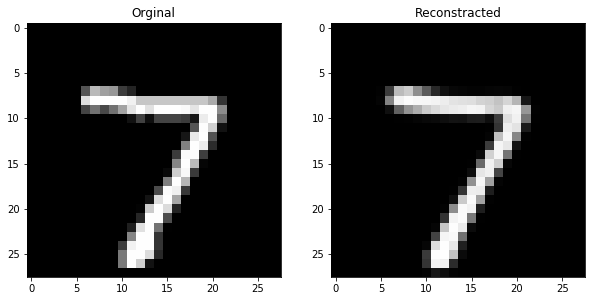

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.title('Orginal')
plt.imshow((img*255).astype(np.uint8).reshape(28, 28), cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.title('Reconstracted')
plt.imshow((pred*255).astype(np.uint8), cmap=plt.cm.gray)
plt.show()


In [0]:

sample=[]
sample_y=[]
for i in np.unique(y_train):
     idx=[j for j in range(y_train.size) if y_train[j]==i]
     idx=idx[0:200]
     sample.append(x_train[idx])
     sample_y.append([i]*200)

In [0]:
sample=np.array(sample).reshape(-1,28,28,1)
sample_y=np.array(sample_y).reshape(-1)

In [0]:
latents=encoder.predict(sample)

In [0]:

from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(latents)


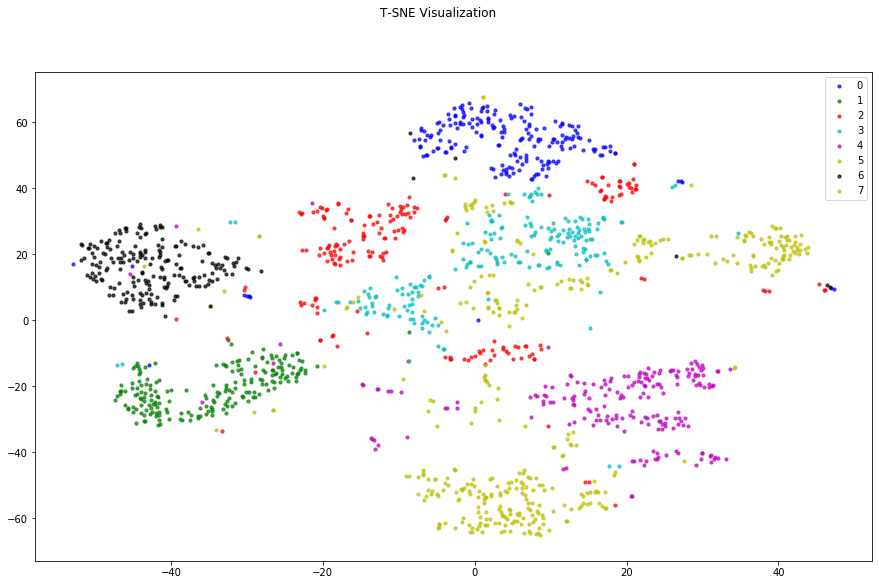

In [28]:


colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k','y']

fig, ax = plt.subplots()
for i in range(8):
    idxs = [j for j in range(sample_y.size) if sample_y[j]==i]
    ax.scatter(X_embedded[idxs,0], 
               X_embedded[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization ',fontsize=12)
fig.set_size_inches(15,9)
plt.show()

In [0]:
clean=encoder.predict(x_train[y_train==3])
noise=clean+np.random.normal(1, 2, clean.shape)

In [0]:
data=np.zeros((clean.shape[0]*2,64))
import random
idx=np.arange(data.shape[0])
random.shuffle(idx)

In [0]:
labels=np.zeros((clean.shape[0]*2,1))

In [0]:
data[idx[0:clean.shape[0]]]=clean
labels[idx[0:clean.shape[0]]]=1
data[idx[clean.shape[0]:]]=noise
labels[idx[clean.shape[0]:]]=0

In [0]:

from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(data)


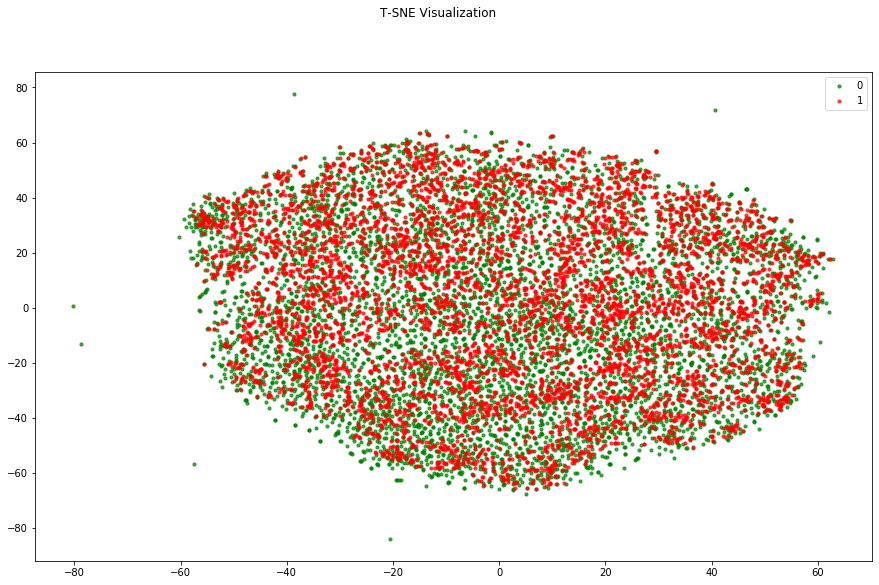

In [56]:
colors = ['g', 'r']

fig, ax = plt.subplots()
for i in range(2):
    idxs = [j for j in range(labels.size) if labels[j]==i]
    ax.scatter(X_embedded[idxs,0], 
               X_embedded[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization ',fontsize=12)
fig.set_size_inches(15,9)
plt.show()

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

from dagmm import DAGMM

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
tf.reset_default_graph()


In [0]:
model_dagmm = DAGMM(
    comp_hiddens=[16,8,1], comp_activation=tf.nn.tanh,
    est_hiddens=[8,4], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=1000, minibatch_size=128
)


In [61]:
model_dagmm.fit(data)

 epoch 100/1000 : loss = 55.937
 epoch 200/1000 : loss = 55.779
 epoch 300/1000 : loss = 55.749
 epoch 400/1000 : loss = 55.741
 epoch 500/1000 : loss = 55.735
 epoch 600/1000 : loss = 55.728
 epoch 700/1000 : loss = 55.713
 epoch 800/1000 : loss = 55.670
 epoch 900/1000 : loss = 54.959
 epoch 1000/1000 : loss = 52.116


In [0]:

energy = model_dagmm.predict(data)

Text(0, 0.5, 'Energy')

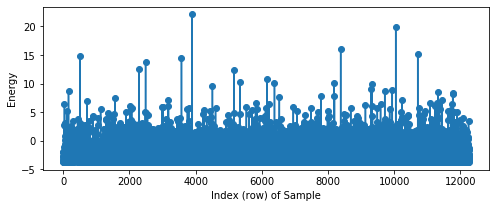

In [63]:
plt.figure(figsize=[8,3])
plt.plot(energy, "o-")
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")

In [0]:
y_pred = model_dagmm.predict(data)

In [65]:
# Energy thleshold to detect anomaly = 80% percentile of energies
anomaly_energy_threshold = np.percentile(y_pred, 80)
print(f"Energy thleshold to detect anomaly : {anomaly_energy_threshold:.3f}")

Energy thleshold to detect anomaly : -1.668


In [0]:
# Detect anomalies from test data
y_pred_flag = np.where(y_pred >= anomaly_energy_threshold, 1, 0)

In [0]:
from sklearn.metrics import precision_recall_fscore_support

In [69]:
prec, recall, fscore, _ = precision_recall_fscore_support(labels, y_pred_flag, average="binary")
print(f" Precision = {prec:.3f}")
print(f" Recall    = {recall:.3f}")
print(f" F1-Score  = {fscore:.3f}")

 Precision = 0.513
 Recall    = 0.205
 F1-Score  = 0.293
